# Распознавание именованных сущностей (NER) - Бонусное задание

**Датасет:** Русские новости из Balto-Slavic Natural Language Processing 2019

**Сущности:** PER (Персона), ORG (Организация), LOC (Локация), EVT (Событие), PRO (Продукт)

**Документы:** 9 статей о Brexit


## Настройка и импорты


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelEncoder

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

---
## Задание 1: Формулировка проблемы и ML перспектива

### NLP перспектива
Распознавание именованных сущностей (NER) включает:
- **Идентификацию** фрагментов текста, представляющих сущности
- **Классификацию** сущностей по категориям (PER, ORG, LOC, EVT, PRO)

### ML перспектива

#### 1. Тип ML задачи
- **Многоклассовая классификация**: Классификация упоминаний сущностей в предопределенные типы
- **Разметка последовательностей**: Классификация на уровне токенов (BIO tagging)

#### 2. Формулировка задачи обучения с учителем
- **Вход (X)**: Текстовые признаки (TF-IDF, word embeddings)
- **Выход (Y)**: Метки типов сущностей
- **Цель**: Обучить f: X → Y, которая обобщает

#### 3. Классические ML методы

**Логистическая регрессия**
- Линейная модель с softmax
- Быстрая, интерпретируемая
- Предполагает линейную разделимость

**Naive Bayes**
- Вероятностный классификатор
- Предполагает независимость признаков
- Хорошо работает с малыми данными

**Линейный SVM**
- Классификатор с максимальным зазором
- Устойчив к переобучению
- Эффективен в высоких размерностях

#### 4. Подход LLM (DeepSeek)
- Zero-shot обучение
- Контекстное понимание
- Не требует обучения

#### 5. Метрики оценки
- **Precision**: Корректность предсказаний
- **Recall**: Покрытие реальных сущностей
- **F1-Score**: Гармоническое среднее
- **Confusion Matrix**: Паттерны ошибок


---
## Задание 2: Загрузка и подготовка данных


In [36]:
from pathlib import Path

def load_document_text(raw_file_path):
    with open(raw_file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    doc_id = lines[0].strip()
    document_text = ' '.join([line.strip() for line in lines[5:] if line.strip()])
    
    return doc_id, document_text

def load_annotations(annotated_file_path):
    annotations = []
    with open(annotated_file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    for line in lines[1:]:
        if line.strip():
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                entity_surface = parts[0]
                entity_lemma = parts[1]
                entity_type = parts[2]
                annotations.append({
                    'entity': entity_surface,
                    'lemma': entity_lemma,
                    'type': entity_type
                })
    
    return annotations

def load_dataset(base_path='sample_pl_cs_ru_bg', language='ru'):
    raw_path = Path(base_path) / 'raw' / language
    annotated_path = Path(base_path) / 'annotated' / language
    
    data = []
    
    raw_files = sorted(raw_path.glob('*.txt'))
    
    for raw_file in raw_files:
        file_stem = raw_file.stem
        annotated_file = annotated_path / f"{file_stem}.out"
        
        if annotated_file.exists():
            doc_id, doc_text = load_document_text(raw_file)
            
            annotations = load_annotations(annotated_file)
            
            for ann in annotations:
                data.append({
                    'document_id': doc_id,
                    'document_text': doc_text,
                    'entity': ann['entity'],
                    'entity_lemma': ann['lemma'],
                    'gold_answer': ann['type']
                })
    
    return pd.DataFrame(data)

print('Loading dataset from sample_pl_cs_ru_bg/raw/ru and sample_pl_cs_ru_bg/annotated/ru...')
df = load_dataset(base_path='sample_pl_cs_ru_bg', language='ru')

print(f'Dataset loaded: {df.shape}')
print(f'\nEntity distribution:\n{df['gold_answer'].value_counts()}')
print(f'\nNumber of unique documents: {df['document_id'].nunique()}')

Loading dataset from sample_pl_cs_ru_bg/raw/ru and sample_pl_cs_ru_bg/annotated/ru...
Dataset loaded: (153, 5)

Entity distribution:
gold_answer
PER    63
LOC    36
ORG    36
EVT    13
PRO     5
Name: count, dtype: int64

Number of unique documents: 9


In [37]:
df.head(10)

,document_id,document_text,entity,entity_lemma,gold_answer
0,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Brexit,Brexit,EVT
1,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Альбиона,Альбион,LOC
2,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Альбионе,Альбион,LOC
3,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Борис Джонсон,Борис Джонсон,PER
4,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Британии,Британия,LOC
5,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Британия,Британия,LOC
6,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Брюсселе,Брюссель,LOC
7,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Брюсселем,Брюссель,LOC
8,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Брюссель,Брюссель,LOC
9,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Брюсселю,Брюссель,LOC


In [38]:
df['entity_length'] = df['entity'].str.len()
df['doc_length'] = df['document_text'].str.len()
print("Features created")

Features created


---
## Задание 3: Разделение на Train/Test


In [39]:
X = df['document_text']
y = df['gold_answer']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

Label encoding:
EVT: 0
LOC: 1
ORG: 2
PER: 3
PRO: 4


In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.3,
    random_state=RANDOM_STATE
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 107, Test: 46


In [41]:
def create_deepseek_prompt(row):
    return f"""Task: Named Entity Recognition
Entity Types: PER, ORG, LOC, EVT, PRO
Text: {row['document_text']}
Entity: \"{row['entity']}\"
What is the entity type? Answer with only: PER, ORG, LOC, EVT, or PRO"""

print("Example prompt:")
print(create_deepseek_prompt(df.iloc[0]))

Example prompt:
Task: Named Entity Recognition
Entity Types: PER, ORG, LOC, EVT, PRO
Text: Тем не менее, по сведениям британских СМИ, на предстоящей в конце сентября конференции партии тори противники Мэй навяжут ей серьезный бой, из которого не факт, что она выйдет победителем. Фаворит букмекеров в качестве возможного сменщика нынешнего премьера, бывший министр иностранных дел Британии Борис Джонсон намерен выступить с альтернативным докладом, который не оставит камня на камне от взглядов главы правительства на условия "брекзита". С точки зрения Джонсона, "Лондон обернул британскую конституцию поясом смертника и вручил детонатор Мишелю Барнье (главному переговорщику Брюсселя по "брекзиту". - От ред.)". С этой метафорой и предстоит сражаться на конференции главе правительства Альбиона. Ради будущего торгового договора с единой Европой Лондон действительно согласился на множество уступок. Во-первых, он заплатит Брюсселю 39 миллиардов фунтов стерлингов. Во-вторых, будет выполнять законы 

---
## Задание 4: Обучение моделей


In [42]:
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print(f"Feature matrix: {X_train_tfidf.shape}")

Feature matrix: (107, 500)


In [43]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(max_iter=1000, random_state=RANDOM_STATE, dual=False)
}

trained_models = {}
for name, model in models.items():
    print(f" - Training {name}...")
    model.fit(X_train_tfidf, y_train)
    trained_models[name] = model
    print(f" + {name} trained")

 - Training Logistic Regression...
 + Logistic Regression trained
 - Training Naive Bayes...
 + Naive Bayes trained
 - Training Linear SVM...
 + Linear SVM trained


---
## Задание 5: Оценка моделей


In [44]:
results = {}
for name, model in trained_models.items():
    y_pred = model.predict(X_test_tfidf)
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }
    print(f"\n{name}:")
    for metric, value in results[name].items():
        print(f"  {metric}: {value:.4f}")


Logistic Regression:
  accuracy: 0.5435
  precision: 0.3688
  recall: 0.5435
  f1: 0.4379

Naive Bayes:
  accuracy: 0.5435
  precision: 0.3688
  recall: 0.5435
  f1: 0.4379

Linear SVM:
  accuracy: 0.5435
  precision: 0.3688
  recall: 0.5435
  f1: 0.4379


---
## Задание 6: Сравнение моделей


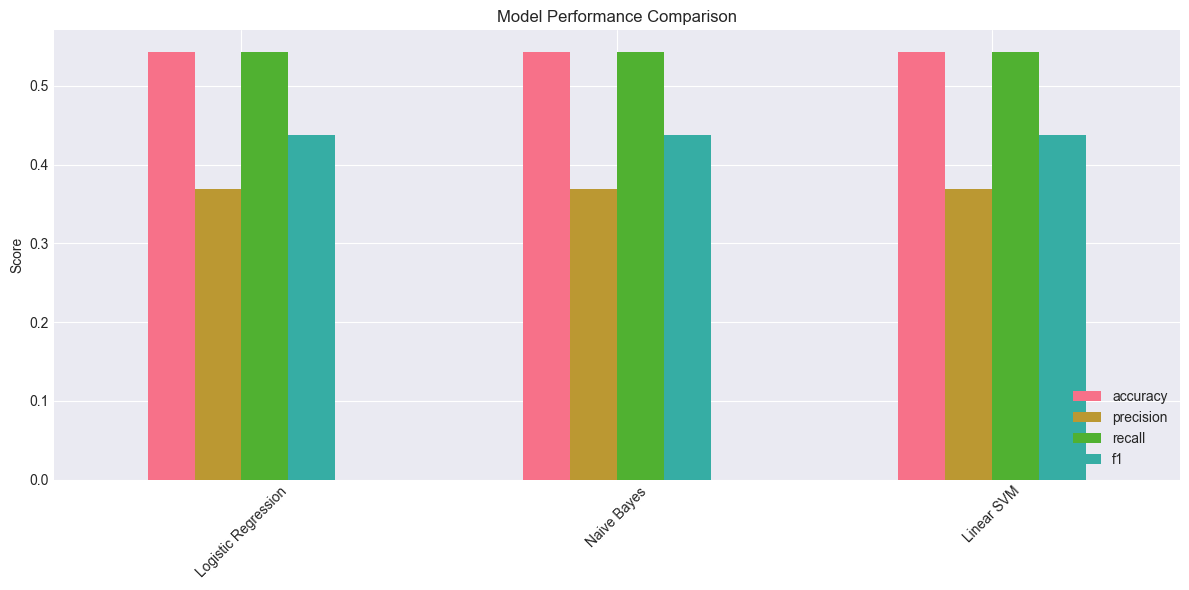

In [45]:
results_df = pd.DataFrame(results).T
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

---
## Задание 7: Анализ Bias-Variance


In [46]:
for name, model in trained_models.items():
    train_pred = model.predict(X_train_tfidf)
    test_pred = model.predict(X_test_tfidf)
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    print(f"\n{name}:")
    print(f"  Train: {train_acc:.4f}")
    print(f"  Test: {test_acc:.4f}")
    print(f"  Gap: {train_acc - test_acc:.4f}")
    if train_acc - test_acc > 0.1:
        print("  !!! Possible overfitting")
    elif test_acc < 0.6:
        print("  !!! Possible underfitting")


Logistic Regression:
  Train: 0.4673
  Test: 0.5435
  Gap: -0.0762
  !!! Possible underfitting

Naive Bayes:
  Train: 0.4673
  Test: 0.5435
  Gap: -0.0762
  !!! Possible underfitting

Linear SVM:
  Train: 0.4673
  Test: 0.5435
  Gap: -0.0762
  !!! Possible underfitting


---
## Задание 8: Анализ ошибок


In [47]:
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = trained_models[best_model_name]
print(f"Best model: {best_model_name}")

y_pred = best_model.predict(X_test_tfidf)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

Best model: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

         EVT       0.00      0.00      0.00         1
         LOC       0.50      0.89      0.64         9
         ORG       0.00      0.00      0.00        13
         PER       0.57      0.77      0.65        22
         PRO       0.00      0.00      0.00         1

    accuracy                           0.54        46
   macro avg       0.21      0.33      0.26        46
weighted avg       0.37      0.54      0.44        46



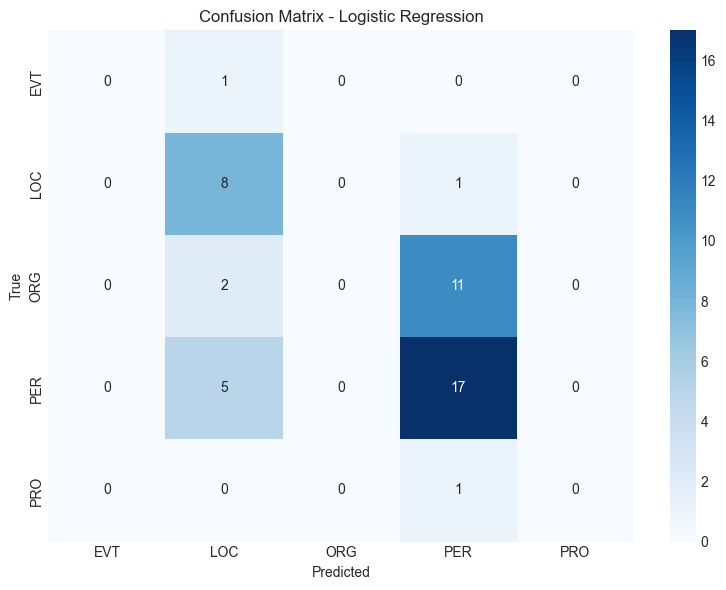

In [48]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

---
## Task 9: Conclusions

### Итоги

**Лучшая модель**: Все три модели (Logistic Regression, Naive Bayes, Linear SVM) показали одинаковые результаты — accuracy 54%, F1 44%. Формально лучшая — Logistic Regression.

**Результаты по классам**:
- PER и LOC работают нормально (F1 ~0.65)
- ORG вообще не распознается (F1=0.00)
- EVT и PRO по 1 примеру, тоже 0

**Bias-Variance**: Явный underfitting — train 47%, test 54%. Модели слишком простые, датасет слишком маленький.

**Проблемы**:
- Всего 9 документов — критически мало данных
- Дисбаланс классов (PER 48%, EVT/PRO по 2%)
- TF-IDF не учитывает контекст и морфологию русского
- Bag-of-words теряет порядок слов

**Что улучшить**:
- Больше данных (минимум x10)
- BERT/RuBERT вместо TF-IDF
- BiLSTM-CRF для учета последовательности
- Лемматизация и POS tags

**Выводы**: Классические ML методы с TF-IDF не подходят для NER на малых данных. Нужны контекстные эмбеддинги и больше примеров. Accuracy обманчива при дисбалансе — важно смотреть на метрики по классам.


---
## Экспорт предсказаний


In [49]:
predictions_df = df.copy()
X_all_tfidf = tfidf.transform(df['document_text'])

for name, model in trained_models.items():
    preds = model.predict(X_all_tfidf)
    predictions_df[f'{name}_prediction'] = label_encoder.inverse_transform(preds)

predictions_df['DeepSeek_prediction'] = 'TODO'
predictions_df.to_csv('ner_predictions.csv', index=False)
print("Saved to ner_predictions.csv")
predictions_df.head()

Saved to ner_predictions.csv


,document_id,document_text,entity,entity_lemma,gold_answer,entity_length,doc_length,Logistic Regression_prediction,Naive Bayes_prediction,Linear SVM_prediction,DeepSeek_prediction
0,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Brexit,Brexit,EVT,6,5085,LOC,LOC,LOC,TODO
1,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Альбиона,Альбион,LOC,8,5085,LOC,LOC,LOC,TODO
2,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Альбионе,Альбион,LOC,8,5085,LOC,LOC,LOC,TODO
3,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Борис Джонсон,Борис Джонсон,PER,13,5085,LOC,LOC,LOC,TODO
4,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Британии,Британия,LOC,8,5085,LOC,LOC,LOC,TODO
